Episode 0: Reward = -324.6, Avg Reward = -324.6
Episode 1: Reward = -66.5, Avg Reward = -66.5
Episode 2: Reward = -356.0, Avg Reward = -356.0
Episode 3: Reward = -263.4, Avg Reward = -263.4
Episode 4: Reward = 21.4, Avg Reward = 21.4
Episode 5: Reward = -313.0, Avg Reward = -313.0
Episode 6: Reward = -110.1, Avg Reward = -110.1
Episode 7: Reward = -229.8, Avg Reward = -229.8
Episode 8: Reward = -423.0, Avg Reward = -423.0
Episode 9: Reward = -174.9, Avg Reward = -174.9
Episode 10: Reward = -150.1, Avg Reward = -150.1
Episode 11: Reward = -102.9, Avg Reward = -102.9
Episode 12: Reward = -96.7, Avg Reward = -96.7
Episode 13: Reward = -171.0, Avg Reward = -171.0
Episode 14: Reward = -210.1, Avg Reward = -210.1
Episode 15: Reward = -61.3, Avg Reward = -61.3
Episode 16: Reward = -60.7, Avg Reward = -60.7
Episode 17: Reward = -360.5, Avg Reward = -360.5
Episode 18: Reward = -86.5, Avg Reward = -86.5
Episode 19: Reward = -130.1, Avg Reward = -130.1
Episode 20: Reward = -191.2, Avg Reward = -1

error: XDG_RUNTIME_DIR not set in the environment.
libEGL warning: failed to open /dev/dri/renderD130: Permission denied

libEGL warning: failed to open /dev/dri/card3: Permission denied

libEGL warning: failed to open /dev/dri/renderD129: Permission denied

libEGL warning: failed to open /dev/dri/card2: Permission denied

libEGL warning: failed to open /dev/dri/renderD128: Permission denied

libEGL warning: failed to open /dev/dri/card1: Permission denied



Test Episode 0: Reward = -395.0
Test Episode 1: Reward = -301.7
Test Episode 2: Reward = -668.9
Test Episode 3: Reward = -308.2
Test Episode 4: Reward = -308.5


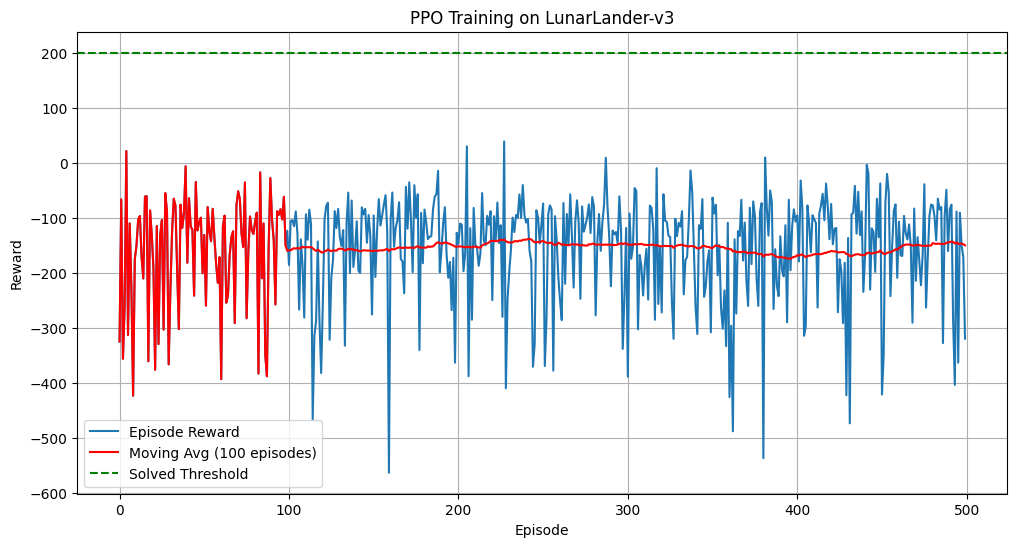

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt
from torch.distributions import Categorical
import torch.nn.functional as F

# 环境初始化
env = gym.make('LunarLander-v3', render_mode='rgb_array')
state_dim = env.observation_space.shape[0]  # 状态维度：8
action_dim = env.action_space.n              # 动作维度：4

# 设置随机种子（确保可复现性）
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
env.reset(seed=seed)

# ===================== 网络架构 ===================== [2,3,8](@ref)
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        # 共享特征提取层
        self.shared = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        # Actor分支（策略网络）
        self.actor = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )
        # Critic分支（价值网络）
        self.critic = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        x = self.shared(x)
        logits = self.actor(x)
        value = self.critic(x)
        return logits, value.squeeze()

# ===================== PPO智能体 ===================== [3,8,9](@ref)
class PPOAgent:
    def __init__(self, state_dim, action_dim):
        self.policy = ActorCritic(state_dim, action_dim)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=3e-4)
        self.gamma = 0.99          # 折扣因子
        self.gae_lambda = 0.95     # GAE参数
        self.eps_clip = 0.2         # Clip阈值
        self.entropy_coef = 0.01    # 熵正则系数
        self.buffer = deque(maxlen=2048)  # 经验池
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy.to(self.device)
        
    def act(self, state):
        """选择动作并返回概率分布"""
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
        with torch.no_grad():
            logits, value = self.policy(state)
        probs = F.softmax(logits, dim=-1)
        dist = Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action).item(), value.item()
    
    def compute_gae(self, rewards, values, dones):
        """修复版GAE计算（解决维度问题）""" # [3,8](@ref)
        advantages = np.zeros_like(rewards)
        last_adv = 0
        next_value = 0  # 终止状态后的值设为0
        
        # 反向计算GAE
        for t in reversed(range(len(rewards))):
            if t == len(rewards) - 1:
                next_non_terminal = 1.0 - dones[t]
                next_value = values[t] * next_non_terminal
            else:
                next_value = values[t+1]
                
            delta = rewards[t] + self.gamma * next_value * (1 - dones[t]) - values[t]
            advantages[t] = delta + self.gamma * self.gae_lambda * (1 - dones[t]) * last_adv
            last_adv = advantages[t]
        return torch.tensor(advantages, dtype=torch.float32).to(self.device)
    
    def update(self):
        """使用收集的数据更新策略"""
        if len(self.buffer) < 512:  # 确保有足够数据
            return
            
        # 解压经验池数据
        states, actions, old_log_probs, rewards, dones, values = zip(*self.buffer)
        
        # 转换为张量
        states = torch.tensor(np.array(states), dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.long).to(self.device)
        old_log_probs = torch.tensor(old_log_probs, dtype=torch.float32).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).to(self.device)
        values = torch.tensor(values, dtype=torch.float32).to(self.device)
        
        # 计算GAE和回报
        advantages = self.compute_gae(rewards.cpu().numpy(), values.cpu().numpy(), dones.cpu().numpy())
        returns = advantages + values
        
        # 策略更新（多个epoch）
        for _ in range(3):  # 通常3-10个epoch
            # 计算新策略的动作概率
            logits, new_values = self.policy(states)
            probs = F.softmax(logits, dim=-1)
            dist = Categorical(probs)
            new_log_probs = dist.log_prob(actions)
            entropy = dist.entropy().mean()
            
            # 计算比率（ratio = exp(new_log_prob - old_log_prob)）
            ratios = torch.exp(new_log_probs - old_log_probs)
            
            # 计算裁剪后的目标函数 [8,9](@ref)
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            actor_loss = -torch.min(surr1, surr2).mean()
            
            # 价值函数损失（Huber损失比MSE更稳定）[3](@ref)
            critic_loss = nn.HuberLoss()(new_values, returns)
            
            # 总损失（包含熵正则）[2,9](@ref)
            total_loss = actor_loss + 0.5 * critic_loss - self.entropy_coef * entropy
            
            # 反向传播
            self.optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
            self.optimizer.step()
        
        # 清空经验池
        self.buffer.clear()

# ===================== 训练主循环 ===================== [1,10](@ref)
if __name__ == "__main__":
    agent = PPOAgent(state_dim, action_dim)
    episode_rewards = []
    avg_rewards = []
    
    for episode in range(500):
        state, _ = env.reset()
        ep_reward = 0
        done = False
        
        while not done:
            # 选择动作
            action, log_prob, value = agent.act(state)
            
            # 执行动作
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # 奖励修正（针对LunarLander环境）
            if done and not (terminated and truncated):  # 坠毁检测
                reward = min(reward, -50)
            
            # 存储经验
            agent.buffer.append((
                state, 
                action,
                log_prob,
                float(reward),
                float(done),
                value
            ))
            
            state = next_state
            ep_reward += reward
            
            # 定期更新策略
            if len(agent.buffer) == agent.buffer.maxlen:
                agent.update()
        
        # 记录本幕奖励
        episode_rewards.append(ep_reward)
        avg_reward = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else ep_reward
        avg_rewards.append(avg_reward)
        
        print(f"Episode {episode}: Reward = {ep_reward:.1f}, Avg Reward = {avg_reward:.1f}")
        
        # 早停条件：连续50幕平均奖励>200
        if len(episode_rewards) > 50 and np.mean(episode_rewards[-50:]) > 200:
            print("Early stopping: Solved environment!")
            break
    
    # 保存训练曲线
    plt.figure(figsize=(12, 6))
    plt.plot(episode_rewards, label='Episode Reward')
    plt.plot(avg_rewards, label='Moving Avg (100 episodes)', color='red')
    plt.axhline(y=200, color='g', linestyle='--', label='Solved Threshold')
    plt.title("PPO Training on LunarLander-v3")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)
    plt.savefig('ppo_training.png')
    
    # 保存模型
    torch.save(agent.policy.state_dict(), 'ppo_lunar.pth')
    
    # ===================== 测试训练好的策略 =====================
    def test_policy(env, policy, episodes=5, render=True):
        for ep in range(episodes):
            state, _ = env.reset()
            done = False
            total_reward = 0
            
            while not done:
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(agent.device)
                with torch.no_grad():
                    logits, _ = policy(state_tensor)
                probs = F.softmax(logits, dim=-1)
                action = torch.argmax(probs).item()
                
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                state = next_state
                total_reward += reward
                
                if render:
                    env.render()
            
            print(f"Test Episode {ep}: Reward = {total_reward:.1f}")
    
    # 创建测试环境
    test_env = gym.make('LunarLander-v3', render_mode='human')
    test_policy(test_env, agent.policy)
    test_env.close()